
### Updates:
1. Estimate statistics based on WHO data ( for the mean of incubation period and recovery period)
2. Estimate the contact rate by the Mcmc simulation result (refer MCMC.ipynb)
3. Estimate the REAL suscepted number by the mean of ratio

### Content:
1. Estimate the new suspects vs new confirm cases ratio ratio <br />
We use it to estimate the real suscepted number 
    1. Warm-up: Estimate using one observation on 7 Feb
    2. Estimate the mean of new suspects vs new confirm cases ratio using the observation between 2020-01-20 to 2020-02-14 (since before 2020-01-20, no suscepted number recorded in dataset)
       - Ratio for China total: 4.167
       - Ratio for Ex-Hubei: 0.59   *(confirm number is Ex-Hubei, but suspect number is China total)*
       - Ratio for Hubei: 13     *(confirm number is Hubei, but suspect number is China total)*

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SEIR_model import *
from helper_fun_epi_model import *
from SEIR_model import SEIR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

#### Load and preprocess data

In [2]:
## Some assumptions
China_population = 1400000000
Hubei_population = 58500000

In [3]:
## Load data 
df = pd.read_csv("../data/DXYArea.csv")

"""
Data Cleaning 
"""
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > datetime.datetime(2019, 12, 7)]  # first day is 2019-12-08
df = df[df['date'] != df['date'].max()] # remove todays' records (since it can be incompleted)

## Dataset preperation
df['R'] = df['cured'] + df['dead']
SIR_data = df[['date', 'Days', 'countryCode','province', 'city', 'net_confirmed', 'suspected', 'R', 
              ]].rename(columns={"net_confirmed": "I", "suspected": "E"})
#SIR_data.tail(3)

In [4]:
# China total

# Use data before 2020-02-14 for train model
China_df = SIR_data[SIR_data['date'] < datetime.datetime(2020, 2, 14)] 
China_total = get_China_total(China_df)
China_total.tail(2)

,date,Days,countryCode,province,city,I,E,R
6436,2020-02-12,66,CN,NaN,NaN,51933,13435,6906
6781,2020-02-13,67,CN,NaN,NaN,55823,10109,8109


### Warm-up: Estimate the new suspects vs new confirm cases ratio using one observation on 7 Feb 
Using China total data 

Using new infected counts of 6 days ago versus suspected counts today ( since the mean incubation duration from WHO is 6 days)

In [5]:
# the "new infected" number on 13 Feb 
I0_diff = list(China_total['I'])[-1] - list(China_total['I'])[-2]
I0_diff

3890

In [6]:
# the recorded total number of Suscepted individuals on 7 Feb
E0_6_diff = list(China_total['E'])[-7] - list(China_total['E'])[-8] 
E0_6_diff

1298

In [7]:
3890/1298

2.9969183359013867

##### We can see that, the ratio of new suspects vs new confirm cases is 3.
So firstly, lets try use this ratio in SEIR model estimation.

In [8]:
def new_SEIR_estimation(data, E0, rateAl, rateIR, population, MCMC_estimate, title):
    ## use the last observation as the initial point in the new SEIR model
    # I is the net confirmed cases (total confirmed case - heal - died)
    I0 = list(data['I'])[-1]
    R0 = list(data['R'])[-1]
    S0 = population - I0 - E0 - R0
    
    est_beta = MCMC_estimate/population # based on MCMC result
    result = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=rateIR, rateAl = rateAl,
             title = title, death_rate=0.02, show_Sus = False)
    
    return result

#### Train SEIR model based on the first guess ratio

Maximum infected case:  56168


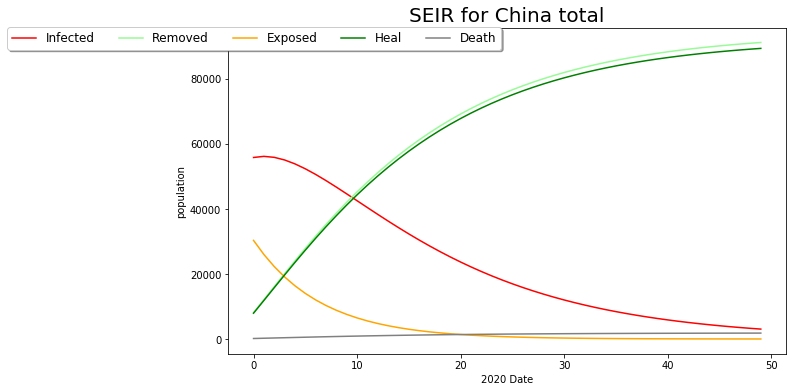

The MAMPE is: 
0.061243983920735774


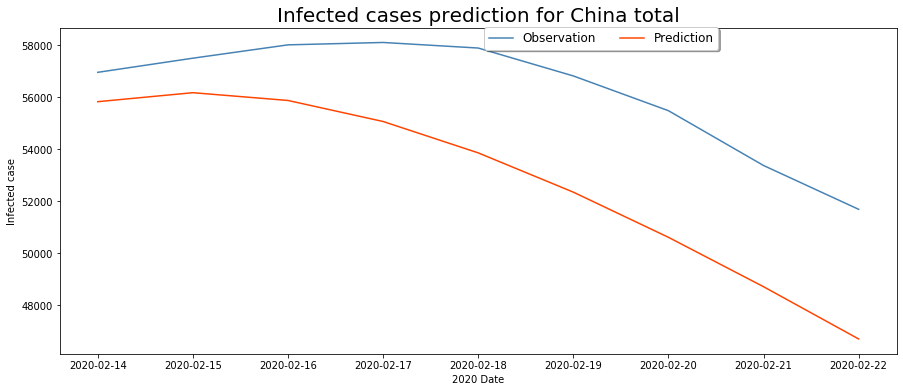

In [9]:
# suppose the real number of suscepted individuals on 13 Feb
E0 = list(China_total['E'])[-1] * 3 # ratio get from result above
population = China_population
MCMC_estimate = 2265.6
rateAl = 1/7
rateIR=1/14
title = 'SEIR for China total'

"""
Calculate MAPE test score using SEIR model result
"""
result = new_SEIR_estimation(China_total, E0, rateAl, rateIR, population, MCMC_estimate, title)
test = get_China_total(SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)])
plot_test_data_with_MAPE(test, result, 'Infected cases prediction for China total')

The forecast result looks not good enough, we under-estimate in the next 9 days. So lets try to estimate the ratio in a better way! 

### Estimate the mean of new suspects vs new confirm cases ratio 
Since using only one observation is not good enough. We try to calculate the mean of ration using more days' observation

We use the data after 2020-01-20, since before that the suscept cases wasnot recorded.

In [10]:
# we use data since 23 Jan (after Wuhan Shut down) 
# since we believe the data is more accurate after this day
list(China_total['date'])[-25]

Timestamp('2020-01-20 00:00:00')

4.167459314172169

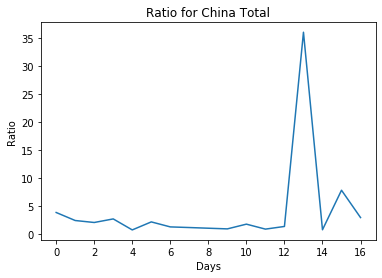

In [11]:
"""
    Find the mean of ratio for China total
    Using the observation between 2020-01-20 to 2020-02-14 to estimate the ratio
"""
i = -25 # obserbvation after 2020-01-20
ratios = []
while(i <=-8):
    I0_diff = list(China_total['I'])[i+7] - list(China_total['I'])[i+6]
    E0_6_diff = list(China_total['E'])[i+1] - list(China_total['E'])[i]
    ratio = I0_diff/E0_6_diff
    
    if ratio >0:
        ratios.append(ratio)
    
    i +=1
plt.title("Ratio for China Total")
plt.ylabel("Ratio")
plt.xlabel("Days")
plt.plot(ratios)     
np.mean(ratios)

### Train SEIR model based on the new estimated ratio
#### Case 1: China total

Maximum infected case:  59096


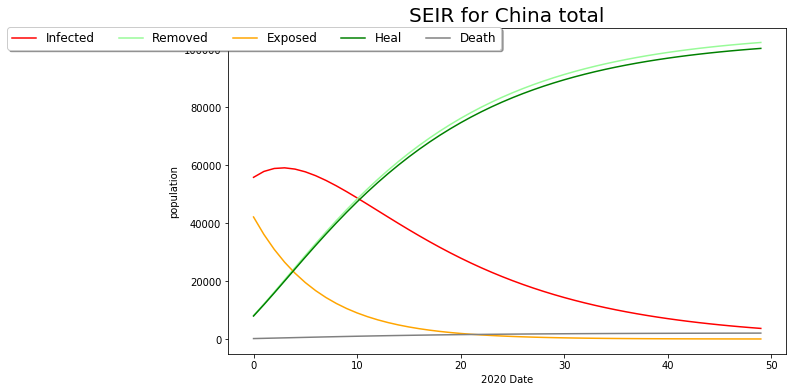

The MAMPE is: 
0.017002346626518897


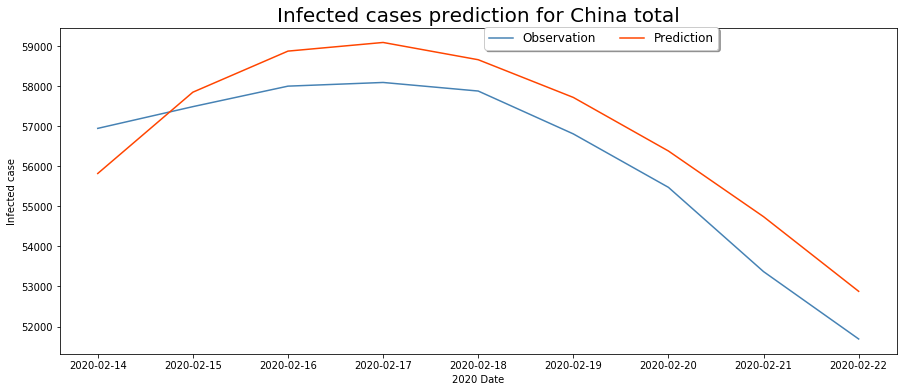

In [12]:
# suppose the real number of suscepted individuals on 13 Feb
E0 = list(China_total['E'])[-1] * np.mean(ratios) 
"""
Calculate MAPE test score using SEIR model result
"""
result = new_SEIR_estimation(China_total, E0, rateAl, rateIR, population, MCMC_estimate, title)
test = get_China_total(SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)])
plot_test_data_with_MAPE(test, result, 'Infected cases prediction for China total')

Maximum infected case:  61058


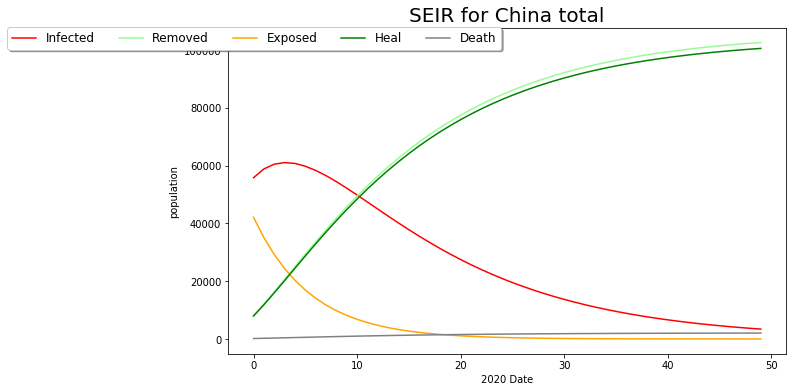

The MAMPE is: 
0.04498901266347166


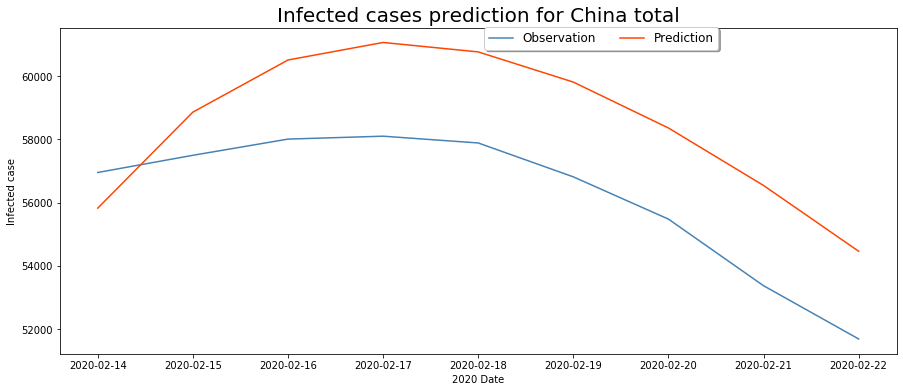

In [13]:
# try shorter incubation period
rateAl = 1/6

result = new_SEIR_estimation(China_total, E0, rateAl, rateIR, population, MCMC_estimate, title)
test = get_China_total(SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)])
plot_test_data_with_MAPE(test, result, 'Infected cases prediction for China total')

From the plot above, we can see that incubation period = 6 is worse than that use incubation period = 7

#### Case 2: Ex-Hubei

In [14]:
NotHubei = get_China_exclude_province(China_df, "Hubei Province") 
# Note that, the E column here is same as China total

0.5857539709446005

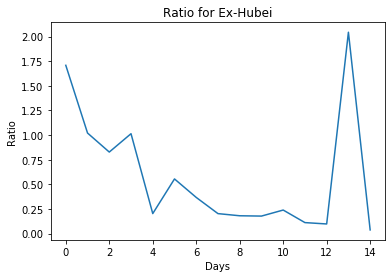

In [15]:
"""
    Try to estimate ratio for Ex-Hubei
    Using the observation between 2020-01-20 to 2020-02-14 to estimate the ratio
"""
i = -25 # obserbvation after 2020-01-20
ratios = []
while(i <=-8):
    I0_diff = list(NotHubei['I'])[i+7] - list(NotHubei['I'])[i+6] # this infected cases in Ex-Hubei
    E0_6_diff = list(NotHubei['E'])[i+1] - list(NotHubei['E'])[i] # note that, this exposed number is China total
    ratio = I0_diff/E0_6_diff
    
    if ratio >0:
        ratios.append(ratio)
    
    i +=1
plt.title("Ratio for Ex-Hubei")
plt.ylabel("Ratio")
plt.xlabel("Days")
plt.plot(ratios)     
np.mean(ratios)

Maximum infected case:  9285


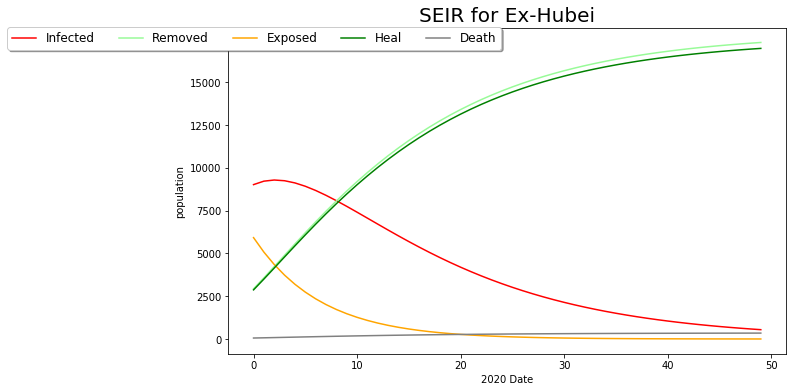

The MAMPE is: 
0.26760994454447473


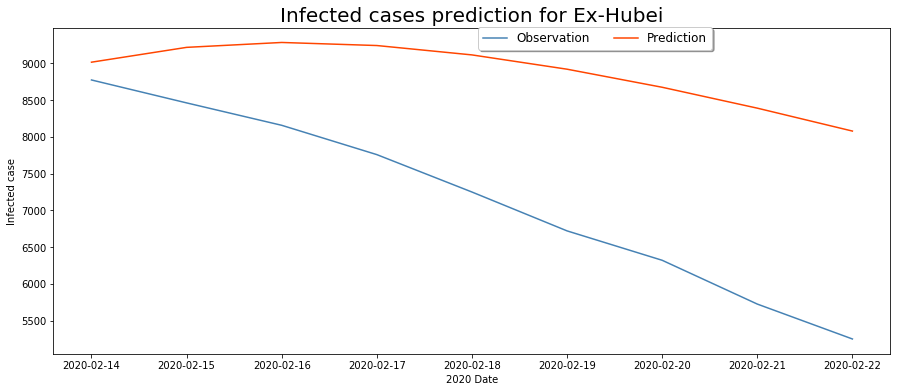

In [16]:
NotHubei = get_China_exclude_province(China_df, "Hubei Province")

NotHubei["E"] = NotHubei["E"] * np.mean(ratios)# Use the estimated ratio 

population = China_population - Hubei_population
MCMC_estimate = 377
E0 = list(NotHubei['E'])[-1] 
rateAl = 1/7
title = 'SEIR for Ex-Hubei'

"""
Calculate MAPE test score using SEIR model result
"""
result2 = new_SEIR_estimation(NotHubei, E0, rateAl, rateIR, population, MCMC_estimate, title)
China_df_test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
test = get_China_exclude_province(China_df_test, "Hubei Province")
plot_test_data_with_MAPE(test, result2, 'Infected cases prediction for Ex-Hubei')

#### Case 3: Hubei

In [17]:
## data process
Hubei = get_province_df(China_df, "Hubei Province").reset_index()
Hubei['E'] = China_total['E'].reset_index()  # Hubei has no pulished data for E

13.095306307821202

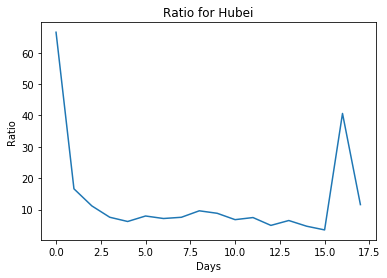

In [18]:
"""
    Find the mean of ratio for Hubei 
    Using the observation between 2020-01-20 to 2020-02-14 to estimate the ratio
"""
i = -25 # obserbvation after 2020-01-20
ratios = []
while(i <=-8):
    I0_diff = list(Hubei['I'])[i+7] - list(Hubei['I'])[i+6]
    E0_6_diff = list(Hubei['E'])[i+1] - list(Hubei['E'])[i] # E is for China total
    ratio = I0_diff/E0_6_diff
    if ratio >0:
        ratios.append(ratio)
    
    i +=1
plt.title("Ratio for Hubei")
plt.ylabel("Ratio")
plt.xlabel("Days")
plt.plot(ratios)   
np.mean(ratios)

Maximum infected case:  73426


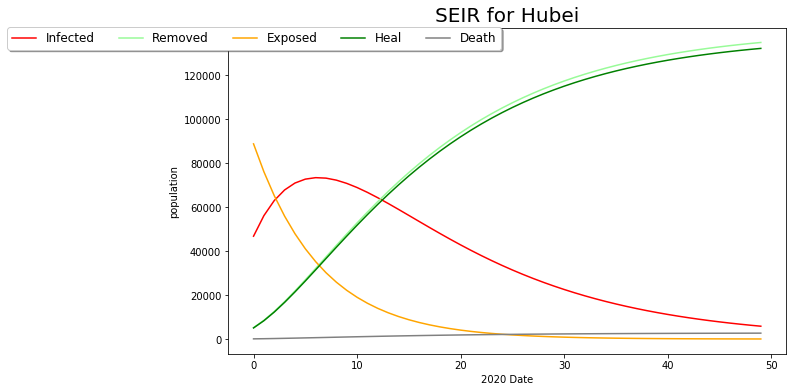

The MAMPE is: 
0.3585040793225176


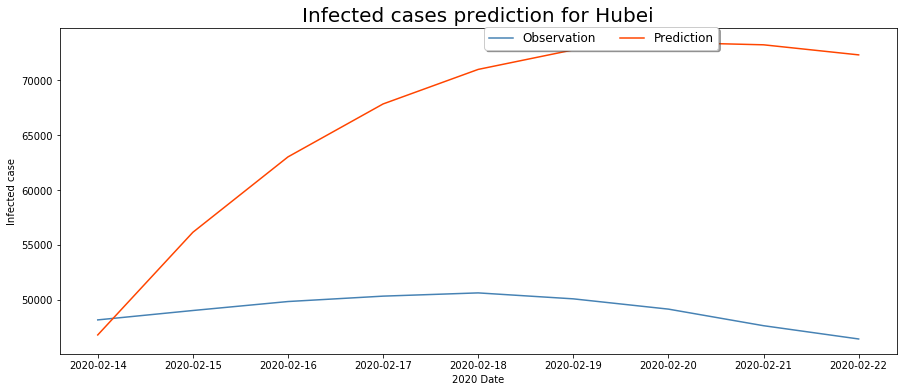

In [19]:
Hubei["E"] = Hubei["E"] * np.mean(ratios)# Use the estimated ratio 

population = Hubei_population
MCMC_estimate = 1488  # MCMC result 
E0 = list(Hubei['E'])[-1] 
rateAl = 1/7
title = 'SEIR for Hubei'

"""
Calculate MAPE test score using SEIR model result
"""
result3 = new_SEIR_estimation(Hubei, E0, rateAl, rateIR, population, MCMC_estimate, title)
China_df_test = SIR_data[SIR_data['date'] >= datetime.datetime(2020, 2, 14)] 
test = get_province_df(China_df_test, "Hubei Province")
plot_test_data_with_MAPE(test, result3, 'Infected cases prediction for Hubei')

From the plot, we can see that the predicted number of infected cases in Hubei is much larger than the reported number.

This result might be reasonable, since there are many ppl died in Hubei without been counted into COVID-19.